In [156]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import acquire_zillow
import prepare_zillow


import pandas as pd
import numpy as np
import seaborn as sns

import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

In [157]:
df = acquire_zillow.read_zillow_csv()

In [158]:
df = prepare_zillow.data_prep(df, cols_to_remove=['airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid',
                              'buildingqualitytypeid', 'propertylandusetypeid', 'typeconstructiontypeid', 
                              'storytypeid', 'heatingorsystemtypeid'])

In [159]:
unit_one = df[(df['unitcnt'] >= 2) & (df['bedroomcnt'] >= 2) & (df['calculatedfinishedsquarefeet'] >= 500)].index    
df.drop(unit_one, inplace=True)

In [160]:
df = df[df.propertylandusedesc != 'Duplex (2 Units, Any Combination)']
df = df[df.propertylandusedesc != 'Quadruplex (4 Units, Any Combination)']
df = df[df.propertylandusedesc != 'Triplex (3 Units, Any Combination)']
df = df[df.propertylandusedesc != 'Condominium']

In [161]:
columns_to_remove = ['heatingorsystemdesc',
                     'censustractandblock',
                     'regionidcity',
                     'finishedsquarefeet12',
                     'rawcensustractandblock',
                     'propertyzoningdesc',
                     'transactiondate',
                     'propertylandusedesc']
df = df.drop(columns_to_remove, axis=1)

#### Handle Missing Values

1. Write or use a previously written function to return the total missing values and the percent missing values by column.

In [162]:
def null_percent_col(df):
    return df.isnull().sum() / df.shape[0] * 100.00

2. Write or use a previously written function to return the total missing values and the percent missing values by row.

In [163]:
def null_percent_row(df):
    return df.isnull().sum() / df.shape[1] * 100.00

3. Write a function that will take a dataframe and list of column names as input and return the dataframe with the null values in those columns replace by 0.

In [164]:
def replace_with_zero(df, column_name):
    df[column_name] = df[column_name].fillna(0)
    return df

4. Impute the values in land square feet.

For land square feet, the goal is to impute the missing values by creating a linear model where landtaxvaluedollarcnt is the x variable and the output/y-variable is the estimated land square feet. We'll then use this model to make predictions and fill in the missing values.

Write a function that accepts the zillow data frame and returns the data frame with the missing values filled in.

In [165]:
def replace_null_data(df, column_name, numerical = True):
    if numerical == True:
        df[column_name] = df[column_name].fillna(df[column_name].mean())
    else:
        df[column_name] = df[column_name].fillna(df[column_name].mode()[0])
    
    return df

df = replace_null_data(df,'landtaxvaluedollarcnt')
df = replace_null_data(df,'yearbuilt')
df = replace_null_data(df,'unitcnt')
df = replace_null_data(df, 'calculatedfinishedsquarefeet')
df = replace_null_data(df, 'lotsizesquarefeet')

5. Create a function that fills missing values with 0s. Explore the data and decide which columns it makes sense to apply this transformation to.

In [166]:
def replace_with_zero(df, column_name):
    df[column_name] = df[column_name].fillna(0)
    return df

df = replace_with_zero(df,'fullbathcnt')
df = replace_with_zero(df,'calculatedbathnbr')
df = replace_with_zero(df, 'taxvaluedollarcnt')
df = replace_with_zero(df, 'regionidzip')
df = replace_with_zero(df, 'taxamount')

6. Run the first function that returns missing value totals by column: Does the attribute have enough information (i.e. enough non-null values) to be useful? Choose your cutoff and remove columns where there is not enough information available. Document your cutoff and your reasoning.

**Documentation of missing values by column:**

Each attribute in the Zillow data could be useful; I chose to look at all the numerical types and fill columns with the NaN value with the mean, and the non-numerical columns with the mode. I am hoping to look at the NaN information in a generalized form; i.e. in a way that it would create a bias in each column towards the mean of that column.

There are columns that will not have a place during and after the train test split and we will look at those further in detail. Currently there are around 100k rows to look at which is plenty of rows to see how each column effects logerror.

7. Run the function that returns missing values by row: Does the observation have enough information to use in our sample? Choose your cutoff and remove rows where there is not enough information available. Document your cutoff and your reasoning.

**Documentation of missing values by row:**

Taking a look at each row comes into play when we want to eliminate certain descriptions of propertylandusedesc from our prepared data. Part of the reasoning of just looking at single unit listings is to focus on the majority. There are around 100k single unit properties while there are only half that of the multi unit properites.

I chose to eliminate Duplex's, Triplex, Quadruplex, and Condominium since these are known to have multi units within each building. The rest of the descriptions could go either way so I created a different function that would eliminate through a different column: 'unitcnt'

8. Of the remaining missing values, can they be imputed or otherwise estimated?

    - Impute those that can be imputed with the method you feel best fits the attribute.
    - Decide whether to remove the rows or columns of any that cannot be reasonably imputed.
    - Document your reasons for the decisions on how to handle each of those.


#### Handle Outliers

1. Write a function that accepts a series (i.e. one column from a data frame) and summarizes how many outliers are in the series. This function should accept a second parameter that determines how outliers are detected, with the ability to detect outliers in 3 ways:

    - Using the IQR
    - Using standard deviations
    - Based on whether the observation is in the top or bottom 1%

In [167]:
keys = ['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet',
                      'structuretaxvaluedollarcnt','landtaxvaluedollarcnt']
values = [(1,7), (1,7), (500,8000), (25000,2000000), (10000,2500000)]

dictionary = dict(zip(keys, values))

for key, value in dictionary.items():
    df = df[df[key] >= value[0]]
    df = df[df[key] <= value[1]]

2. Use your function defined above to identify columns where you should handle the outliers.

3. Write a function that accepts the zillow data frame and removes the outliers. You should make a decision and document how you will remove outliers.

4. Is there erroneous data you have found that you need to remove or repair? If so, take action.

5. Are there outliers you want to "squeeze in" to a max value? (e.g. all bathrooms > 6 => bathrooms = 6). If so, make those changes.

### Exploration -- Tips Data

In [168]:
import seaborn as sns

df_tips = sns.load_dataset('tips')

In [169]:
df_tips.dtypes

total_bill     float64
tip            float64
sex           category
smoker        category
day           category
time          category
size             int64
dtype: object

In [170]:
obj_df = df_tips.select_dtypes(include=['category']).copy()
obj_df.head()

,sex,smoker,day,time
0,Female,No,Sun,Dinner
1,Male,No,Sun,Dinner
2,Male,No,Sun,Dinner
3,Male,No,Sun,Dinner
4,Female,No,Sun,Dinner


In [171]:
df_tips.day.value_counts()

Sat     87
Sun     76
Thur    62
Fri     19
Name: day, dtype: int64

In [172]:
def sex_to_numeric(x):
    if x=='Male':
        return 2
    if x=='Female':
        return 1

def time_to_numeric(x):
    if x=='Dinner':
        return 2
    if x=='Lunch':
        return 1

def smoker_to_numeric(x):
    if x=='Yes':
        return 2
    if x=='No':
        return 1

def day_to_numeric(x):
    if x=='Sat':
        return 4
    if x=='Fri':
        return 3
    if x=='Thur':
        return 2
    if x=='Sun':
        return 1

In [173]:
df_tips['sex_num'] = df_tips['sex'].apply(sex_to_numeric)
df_tips['time_num'] = df_tips['time'].apply(time_to_numeric)
df_tips['smoker_num'] = df_tips['smoker'].apply(smoker_to_numeric)
df_tips['day_num'] = df_tips['day'].apply(day_to_numeric)

In [174]:
df_tips['tip_bin'] = pd.qcut(df_tips.tip, 4, labels=False)

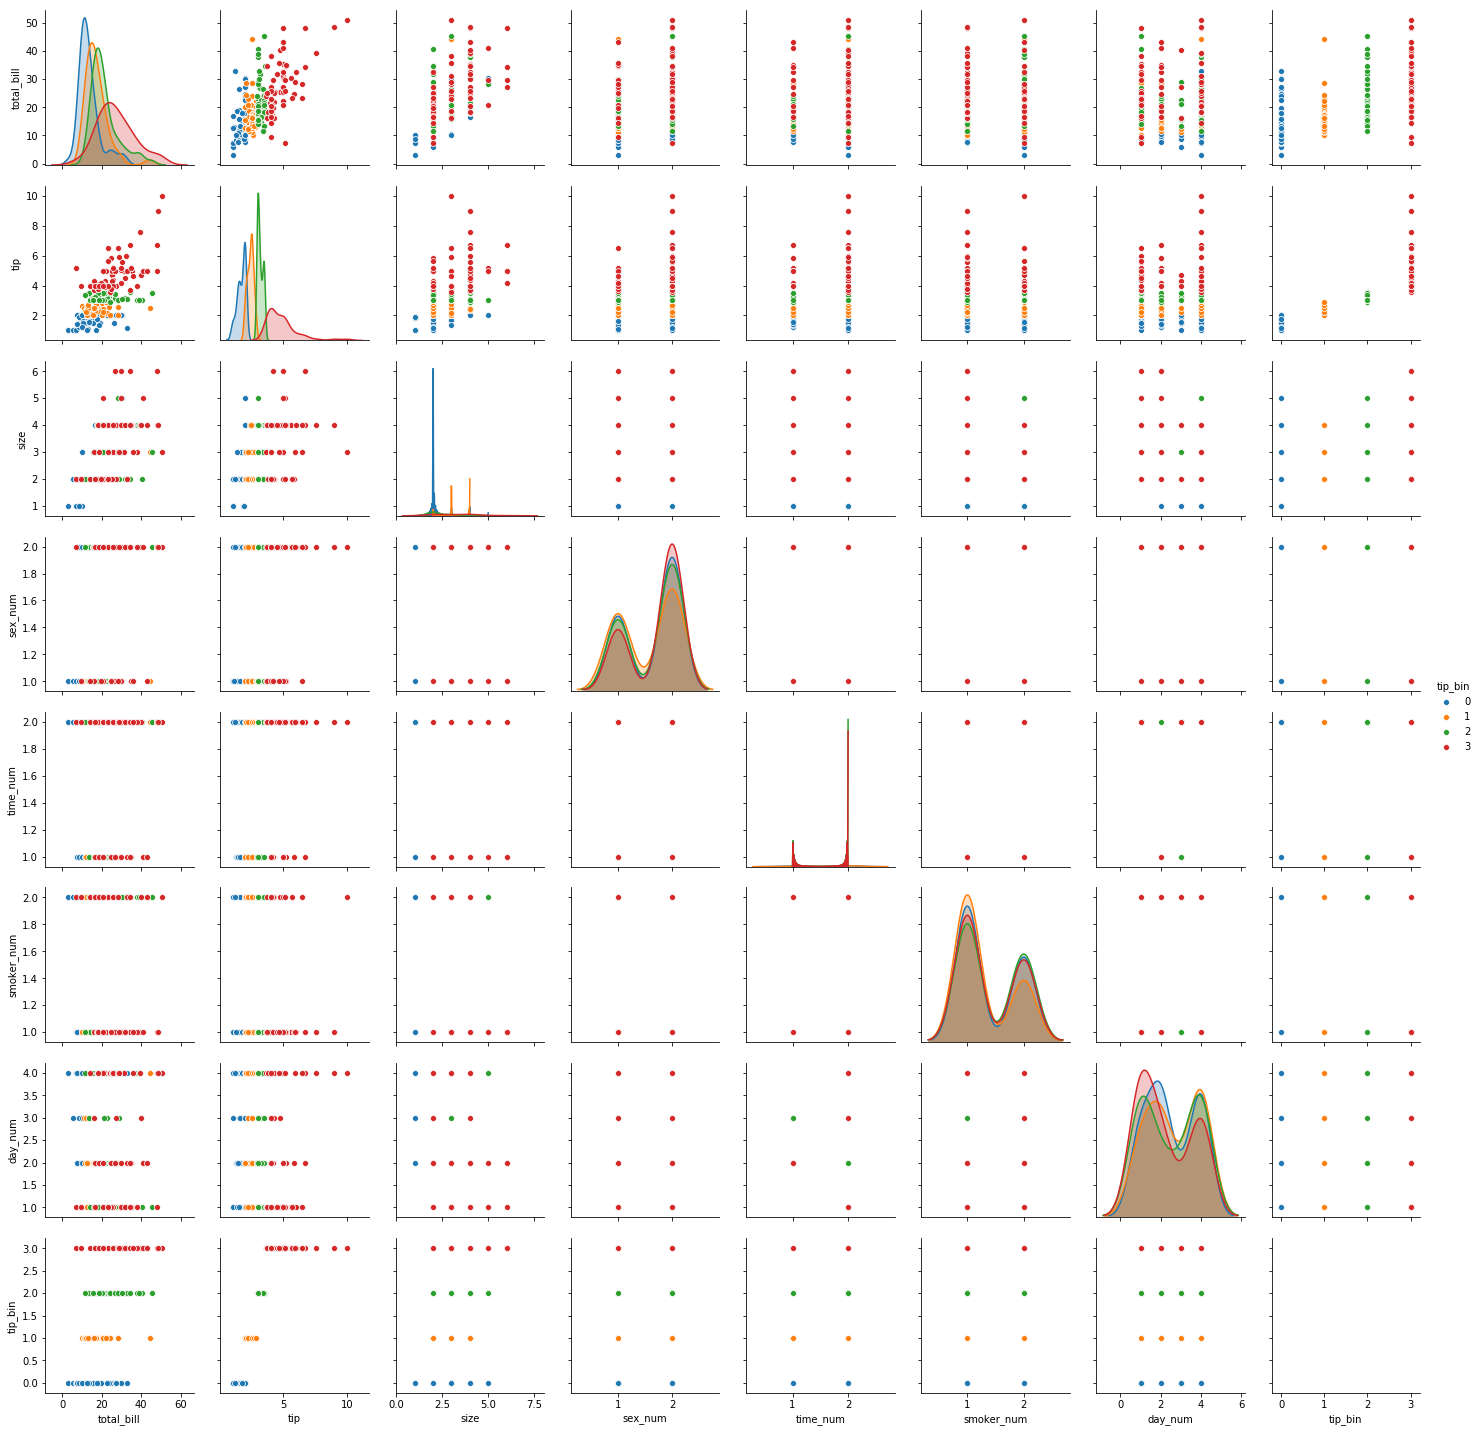

In [175]:
sns.pairplot(df_tips, hue='tip_bin')

In [176]:
stats.ttest_ind(df_tips[df_tips.sex_num == 1].tip.dropna(),
               df_tips[df_tips.sex_num == 2].tip.dropna())

Ttest_indResult(statistic=-1.3878597054212687, pvalue=0.16645623503456763)

In [177]:
stats.ttest_ind(df_tips[df_tips.smoker_num == 1].tip.dropna(),
               df_tips[df_tips.smoker_num == 2].tip.dropna())

Ttest_indResult(statistic=-0.09222805186888201, pvalue=0.9265931522244976)

**Winner, Winner, Chicken Dinner!**

In [178]:
stats.ttest_ind(df_tips[df_tips.time_num == 1].tip.dropna(),
               df_tips[df_tips.time_num == 2].tip.dropna())

Ttest_indResult(statistic=-1.9062569301202392, pvalue=0.05780153475171558)

In [179]:
df_tips['tip_bin'] = pd.qcut(df_tips.tip, 3, labels=False)
df_tips.head()

,total_bill,tip,sex,smoker,day,time,size,sex_num,time_num,smoker_num,day_num,tip_bin
0,16.99,1.01,Female,No,Sun,Dinner,2,1,2,1,1,0
1,10.34,1.66,Male,No,Sun,Dinner,3,2,2,1,1,0
2,21.01,3.50,Male,No,Sun,Dinner,3,2,2,1,1,2
3,23.68,3.31,Male,No,Sun,Dinner,2,2,2,1,1,2
4,24.59,3.61,Female,No,Sun,Dinner,4,1,2,1,1,2


Text(0.5, 1.0, 'Tip Amount by Sex')

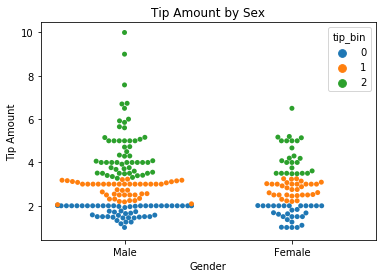

In [180]:
sns.swarmplot(x="sex", y="tip", data=df_tips, hue='tip_bin')
plt.ylabel('Tip Amount')
plt.xlabel('Gender')
plt.title('Tip Amount by Sex')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a42a29a20>,
      dtype=object)

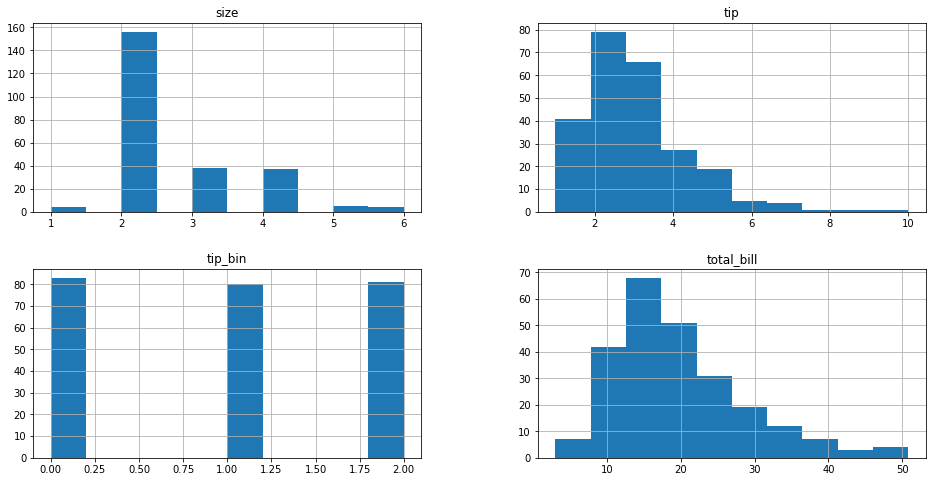

In [181]:
df_tips.hist(figsize=(16, 8), log=False)

### Explore -- Zillow Data

Write a function that will take, as input, a dataframe and a list containing the column names of all ordered numeric variables. It will output, through subplots, a pairplot, a heatmap, and 1 other type of plot that will loop through and plot each combination of numeric variables (an x and a y, combination order doesn't matter here!).

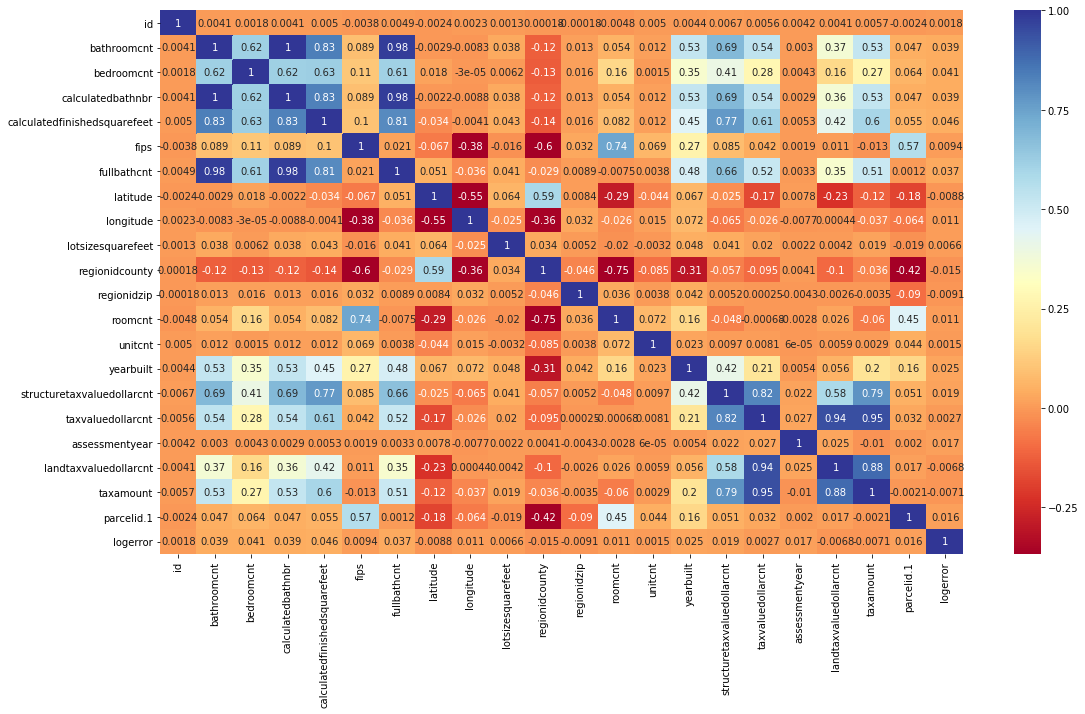

In [182]:
num_cols = df.select_dtypes(exclude=['object'])

plt.figure(figsize=(18,10))
sns.heatmap(num_cols.corr(), annot=True, cmap='RdYlBu', robust=True)

In [183]:
corrs = df.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(10)

,level_0,level_1,0
412,regionidcounty,latitude,0.589450
413,latitude,regionidcounty,0.589450
414,calculatedfinishedsquarefeet,taxamount,0.597927
415,taxamount,calculatedfinishedsquarefeet,0.597927
416,regionidcounty,fips,0.601059
417,fips,regionidcounty,0.601059
418,bedroomcnt,fullbathcnt,0.610248
419,fullbathcnt,bedroomcnt,0.610248
420,calculatedfinishedsquarefeet,taxvaluedollarcnt,0.614513
421,taxvaluedollarcnt,calculatedfinishedsquarefeet,0.614513


In [184]:
df['absolute_logerror']= abs(df['logerror'])

In [185]:
df['logerror_bin'] = pd.qcut(df.absolute_logerror, 4, labels=["good", "medium-", "medium+", "bad"])

In [186]:
df['logerror_bin'].value_counts()

good       28612
medium+    28239
bad        28149
medium-    27776
Name: logerror_bin, dtype: int64

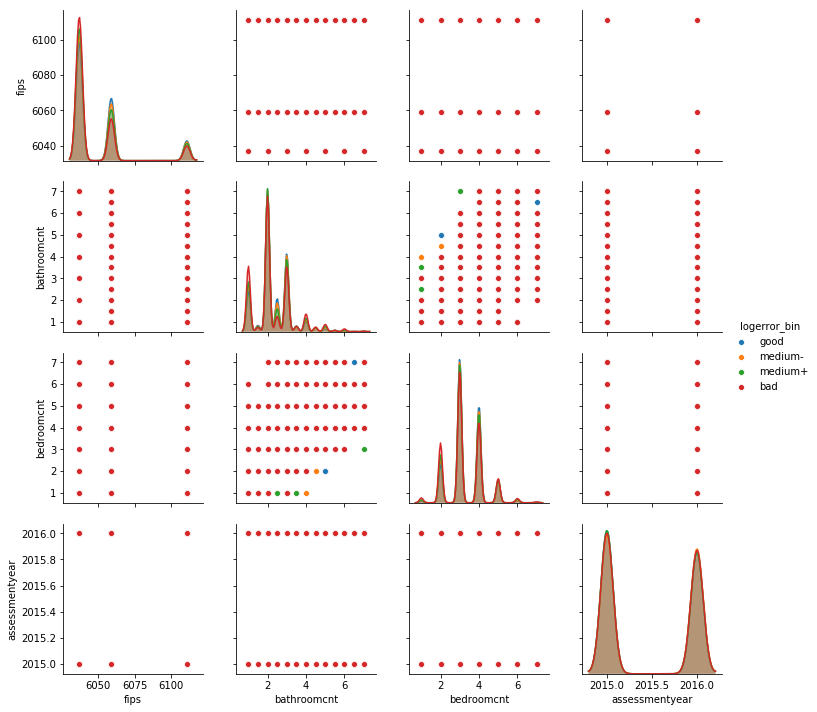

In [187]:
sns.pairplot(df, vars=['fips', 'bathroomcnt', 'bedroomcnt', 'assessmentyear'], hue='logerror_bin')

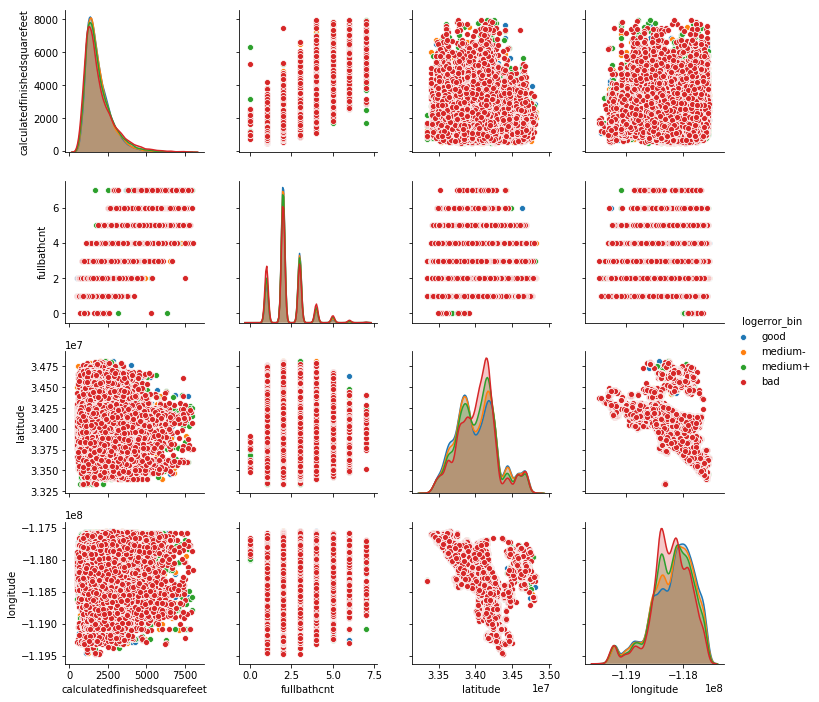

In [188]:
sns.pairplot(df, vars=['calculatedfinishedsquarefeet', 'fullbathcnt', 'latitude', 'longitude'], hue='logerror_bin')

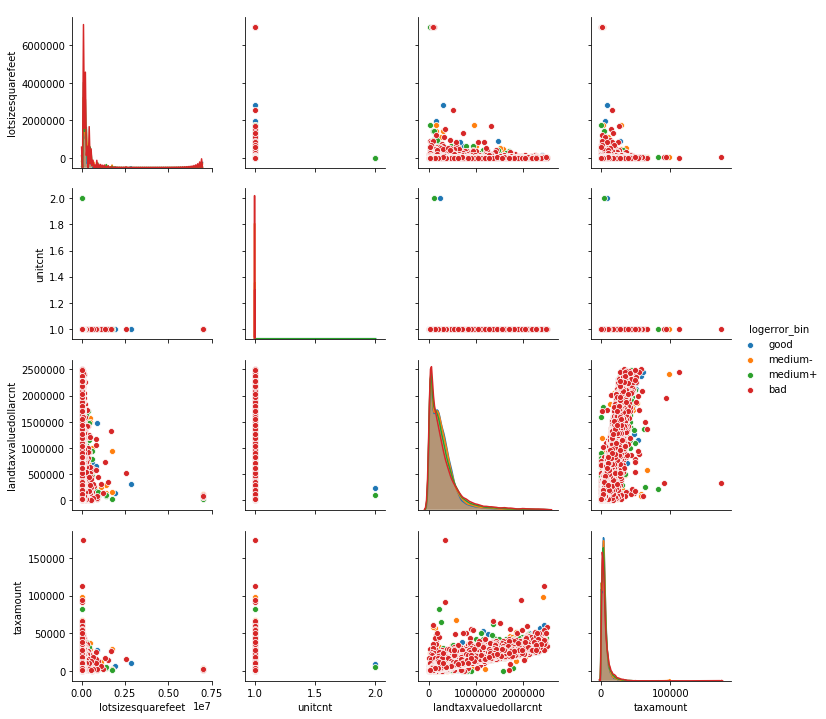

In [189]:
sns.pairplot(df, vars=['lotsizesquarefeet', 'unitcnt', 'landtaxvaluedollarcnt', 'taxamount'], hue='logerror_bin')

Write a function that will use seaborn's relplot to plot 2 numeric (ordered) variables and 1 categorical variable. It will take, as input, a dataframe, column name indicated for each of the following: x, y, & hue.

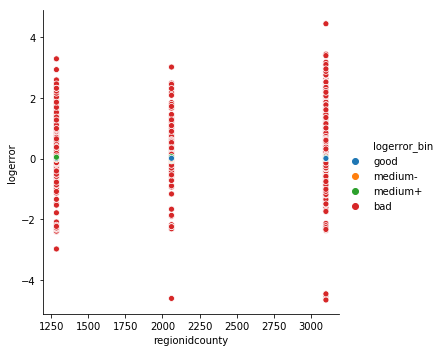

In [190]:
sns.relplot(x="regionidcounty", y="logerror", hue="logerror_bin", data=df)

Write a function that will take, as input, a dataframe, a categorical column name, and a list of numeric column names. It will return a series of subplots: a swarmplot for each numeric column. X will be the categorical variable.

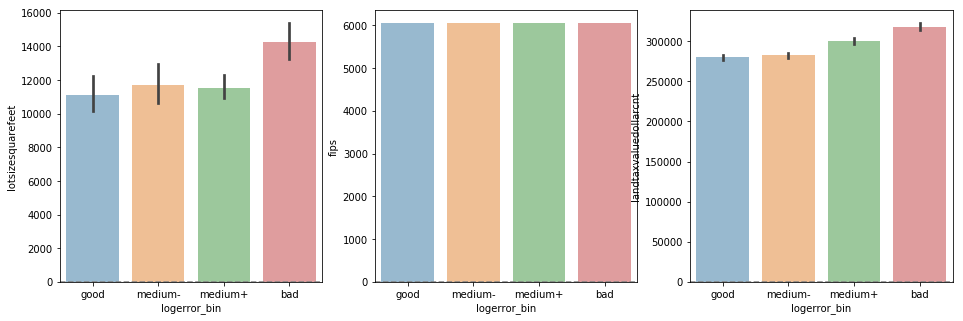

In [191]:
logerror_rate = df.logerror.mean()

features = ['lotsizesquarefeet', 'fips', 'landtaxvaluedollarcnt']

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,5))

for i, feature in enumerate(features):
    sns.barplot('logerror_bin', feature, data=df, ax=ax[i], alpha=.5)
    ax[i].axhline(logerror_rate, ls='--', color='grey')

Write a function that will take a dataframe and a list of categorical columns to plot each combination of variables in the chart type of your choice.

In [192]:
'''
print('Distributions of 24 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(df.columns)[2:24]):
    plt.subplot(6, 4, i + 1)
    plt.hist(df[col])
    plt.title(col)
'''

"\nprint('Distributions of 24 columns')\nplt.figure(figsize=(26, 24))\nfor i, col in enumerate(list(df.columns)[2:24]):\n    plt.subplot(6, 4, i + 1)\n    plt.hist(df[col])\n    plt.title(col)\n"

Explore, explore, explore! Use the functions you wrote above to create plots, and explore some more with other plots.

Test, test, test!

**TTesting in progress***

In [193]:
stats.ttest_ind(df[df.yearbuilt > 1962].logerror.dropna(),
               df[df.yearbuilt < 1962].logerror.dropna())

Ttest_indResult(statistic=7.985776126310062, pvalue=1.4096918698559898e-15)

In [194]:
stats.ttest_ind(df[df.calculatedfinishedsquarefeet > 1660].logerror.dropna(),
               df[df.calculatedfinishedsquarefeet < 1660].logerror.dropna())

Ttest_indResult(statistic=9.489990389812524, pvalue=2.3534208169024236e-21)

In [195]:
stats.ttest_ind(df[df.lotsizesquarefeet < 10000].logerror.dropna(),
               df[df.lotsizesquarefeet > 10000].logerror.dropna())

Ttest_indResult(statistic=-7.642731971210034, pvalue=2.143315880038566e-14)

In [196]:
stats.ttest_ind(df[df.fips > 6075].logerror.dropna(),
               df[df.fips < 6075].logerror.dropna())

Ttest_indResult(statistic=1.068451483736277, pvalue=0.28531919115137566)

In [197]:
stats.ttest_ind(df[df.regionidzip > 96995].logerror.dropna(),
               df[df.regionidzip < 96995].logerror.dropna())

Ttest_indResult(statistic=0.7823261786069449, pvalue=0.43402455947320606)

In [198]:
stats.ttest_ind(df[df.taxvaluedollarcnt > df.taxvaluedollarcnt.mean()].logerror.dropna(),
               df[df.taxvaluedollarcnt < df.taxvaluedollarcnt.mean()].logerror.dropna())

Ttest_indResult(statistic=0.20159343109452788, pvalue=0.8402349446243776)

**Winner, Winner, Chicken Dinner!**

In [199]:
stats.ttest_ind(df[df.landtaxvaluedollarcnt < 200000].logerror.dropna(),
               df[df.landtaxvaluedollarcnt > 200000].logerror.dropna())

Ttest_indResult(statistic=4.001810812619075, pvalue=6.289969037574019e-05)

**Chi^2'd testing in progress**

In [200]:
crosstab = pd.crosstab(df['assessmentyear'] > 2015, df['logerror'])
stats.chi2_contingency(crosstab)

(112776.0,
 0.0,
 53774,
 array([[0.5347237, 1.0694474, 0.5347237, ..., 0.5347237, 0.5347237,
         0.5347237],
        [0.4652763, 0.9305526, 0.4652763, ..., 0.4652763, 0.4652763,
         0.4652763]]))

In [201]:
crosstab = pd.crosstab(df['bathroomcnt'], df['logerror'])
stats.chi2_contingency(crosstab)

(647896.0058071644,
 0.010917966813623016,
 645288,
 array([[1.56176846e-01, 3.12353692e-01, 1.56176846e-01, ...,
         1.56176846e-01, 1.56176846e-01, 1.56176846e-01],
        [1.65904093e-02, 3.31808186e-02, 1.65904093e-02, ...,
         1.65904093e-02, 1.65904093e-02, 1.65904093e-02],
        [4.25844151e-01, 8.51688302e-01, 4.25844151e-01, ...,
         4.25844151e-01, 4.25844151e-01, 4.25844151e-01],
        ...,
        [4.85918990e-03, 9.71837980e-03, 4.85918990e-03, ...,
         4.85918990e-03, 4.85918990e-03, 4.85918990e-03],
        [5.67496630e-04, 1.13499326e-03, 5.67496630e-04, ...,
         5.67496630e-04, 5.67496630e-04, 5.67496630e-04],
        [1.10839186e-03, 2.21678371e-03, 1.10839186e-03, ...,
         1.10839186e-03, 1.10839186e-03, 1.10839186e-03]]))

In [202]:
crosstab = pd.crosstab(df['bedroomcnt'], df['logerror'])
stats.chi2_contingency(crosstab)

(335718.29172344983,
 2.363114304000569e-58,
 322644,
 array([[0.00926616, 0.01853231, 0.00926616, ..., 0.00926616, 0.00926616,
         0.00926616],
        [0.15250585, 0.3050117 , 0.15250585, ..., 0.15250585, 0.15250585,
         0.15250585],
        [0.45376676, 0.90753352, 0.45376676, ..., 0.45376676, 0.45376676,
         0.45376676],
        ...,
        [0.07396077, 0.14792154, 0.07396077, ..., 0.07396077, 0.07396077,
         0.07396077],
        [0.01023267, 0.02046535, 0.01023267, ..., 0.01023267, 0.01023267,
         0.01023267],
        [0.00143648, 0.00287295, 0.00143648, ..., 0.00143648, 0.00143648,
         0.00143648]]))

In [203]:
crosstab = pd.crosstab(df['yearbuilt'], df['logerror'])
stats.chi2_contingency(crosstab)

(7595700.681633945,
 0.0,
 7151942,
 array([[8.86713485e-06, 1.77342697e-05, 8.86713485e-06, ...,
         8.86713485e-06, 8.86713485e-06, 8.86713485e-06],
        [8.86713485e-06, 1.77342697e-05, 8.86713485e-06, ...,
         8.86713485e-06, 8.86713485e-06, 8.86713485e-06],
        [7.09370788e-05, 1.41874158e-04, 7.09370788e-05, ...,
         7.09370788e-05, 7.09370788e-05, 7.09370788e-05],
        ...,
        [2.42072781e-03, 4.84145563e-03, 2.42072781e-03, ...,
         2.42072781e-03, 2.42072781e-03, 2.42072781e-03],
        [6.91636518e-04, 1.38327304e-03, 6.91636518e-04, ...,
         6.91636518e-04, 6.91636518e-04, 6.91636518e-04],
        [1.77342697e-05, 3.54685394e-05, 1.77342697e-05, ...,
         1.77342697e-05, 1.77342697e-05, 1.77342697e-05]]))

**Winner, Winner, Chicken Dinner!**

In [204]:
crosstab = pd.crosstab(df['fips'], df['logerror'])
chi2_value, p_value, dof, expected = stats.chi2_contingency(crosstab)

print("The p-value: {}".format(p_value))

The p-value: 0.0031145827589725583


Binning the landtaxvaluedollarcnt to then run a Chi2 test

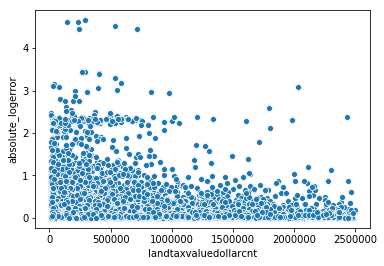

In [205]:
sns.scatterplot(df.landtaxvaluedollarcnt, df.absolute_logerror)

In [206]:
df['landtaxvaluedollarcnt_bin'] = pd.qcut(df.landtaxvaluedollarcnt, 4)

In [207]:
crosstab = pd.crosstab(df['landtaxvaluedollarcnt_bin'], df['logerror'])
chi2_value, p_value, dof, expected = stats.chi2_contingency(crosstab)

print("The p-value: {}".format(p_value))

The p-value: 0.1137479210441069


### Clustering

In [208]:
df.columns

Index(['id', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'fips', 'fullbathcnt', 'latitude',
       'longitude', 'lotsizesquarefeet', 'propertycountylandusecode',
       'regionidcounty', 'regionidzip', 'roomcnt', 'unitcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'parcelid.1', 'logerror',
       'absolute_logerror', 'logerror_bin', 'landtaxvaluedollarcnt_bin'],
      dtype='object')

In [209]:
from sklearn.cluster import KMeans

In [210]:
X = df[['yearbuilt', 'fips', 'landtaxvaluedollarcnt']]

In [211]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

kmeans.predict(X)

array([4, 4, 0, ..., 0, 0, 4], dtype=int32)

In [212]:
kmeans.cluster_centers_

array([[   1963.98300082,    6047.8321245 ,   81155.48487434],
       [   1968.20053413,    6051.2074968 ,  535202.09125385],
       [   1969.12180747,    6045.72892209, 1748449.99466386],
       [   1966.39359597,    6046.92120885,  976859.07537336],
       [   1964.52666246,    6050.89313794,  282911.00984114]])

In [213]:
pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)\
    .reset_index()\
    .rename({'index': 'cluster'}, axis=1)\
    .set_index('cluster')

,yearbuilt,fips,landtaxvaluedollarcnt
cluster,,,
0,1963.983001,6047.832124,8.115548e+04
1,1968.200534,6051.207497,5.352021e+05
2,1969.121807,6045.728922,1.748450e+06
3,1966.393596,6046.921209,9.768591e+05
4,1964.526662,6050.893138,2.829110e+05


In [214]:
df['cluster'] = kmeans.predict(X)
df.cluster.value_counts()

0    49194
4    37399
1    18740
3     5567
2     1876
Name: cluster, dtype: int64

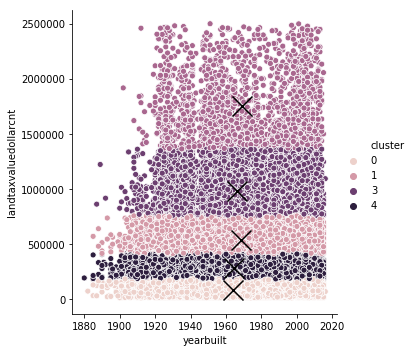

In [215]:

centers = df.groupby('cluster').mean()


sns.relplot(data=df, x='yearbuilt', y='landtaxvaluedollarcnt', hue='cluster')
plt.scatter(centers.yearbuilt, centers.landtaxvaluedollarcnt, s=400, marker='x', c='black', label='center')

<Figure size 2160x1440 with 0 Axes>

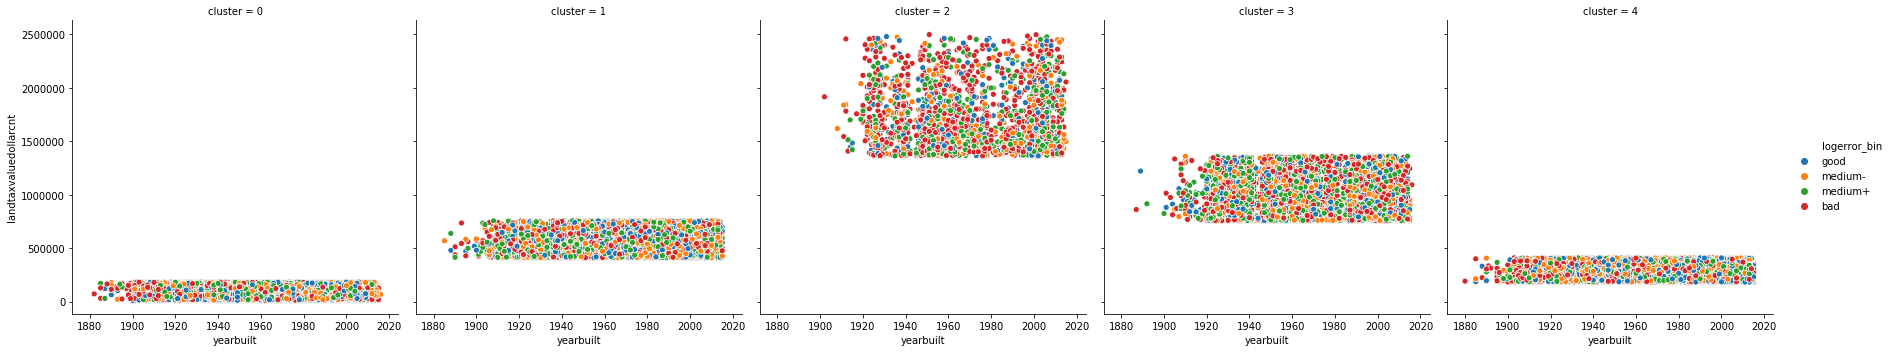

In [216]:
df['cluster'] = kmeans.predict(X)

plt.figure(figsize=(30,20))
sns.relplot(data=df, x='yearbuilt', y='landtaxvaluedollarcnt', hue='logerror_bin', col="cluster")

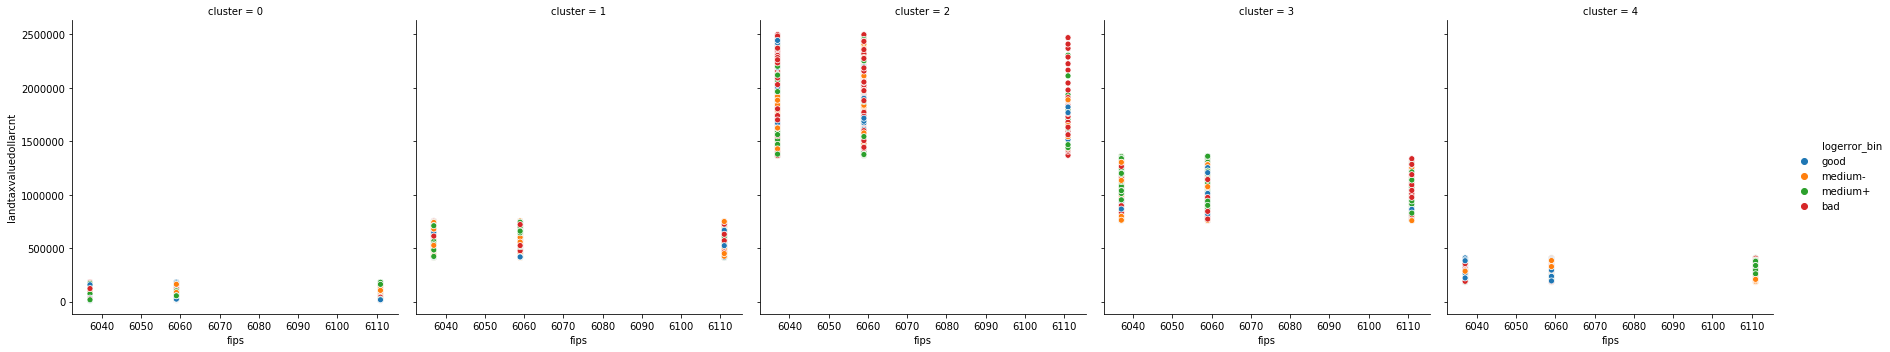

In [217]:
sns.relplot(data=df, x='fips', y='landtaxvaluedollarcnt', hue='logerror_bin', col="cluster")

In [219]:
crosstab = pd.crosstab(df['cluster'] == 2, df['logerror'])
stats.chi2_contingency(crosstab)

(60013.39117502662,
 2.0586092583579625e-75,
 53774,
 array([[0.98336526, 1.96673051, 0.98336526, ..., 0.98336526, 0.98336526,
         0.98336526],
        [0.01663474, 0.03326949, 0.01663474, ..., 0.01663474, 0.01663474,
         0.01663474]]))

In [220]:
crosstab = pd.crosstab(df['cluster'] == 3, df['logerror'])
stats.chi2_contingency(crosstab)

(58427.65781566979,
 1.2304375744753026e-43,
 53774,
 array([[0.95063666, 1.90127332, 0.95063666, ..., 0.95063666, 0.95063666,
         0.95063666],
        [0.04936334, 0.09872668, 0.04936334, ..., 0.04936334, 0.04936334,
         0.04936334]]))

In [221]:
stats.ttest_ind(df[df.cluster == 2].logerror.dropna(),
               df[df.cluster == 3].logerror.dropna())

Ttest_indResult(statistic=-2.6460156596672437, pvalue=0.00816173902776958)

### Logistic Regression Model

In [145]:
X = df.drop(['yearbuilt','landtaxvaluedollarcnt', 'fips', 
             'logerror_bin', 'landtaxvaluedollarcnt_bin', 
             'propertycountylandusecode'], axis=1)
y = df[['logerror']]

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.70, random_state=123)

In [222]:
logit = LogisticRegression(C=1, class_weight={1:2}, random_state = 123, solver='saga')
logit.fit(X_train, y_train)

ValueError: Unknown label type: 'continuous'